<h1>Geospatial Data Science</h1>
<h2>Geospatial Data Visualization: Dot Density Maps</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>

Based on Kyle Pennel's workflow [Create Census Dot Density Data in JupyterLab and HEAVY.AI](https://www.heavy.ai/blog/create-census-dot-density-data-in-jupyterlab-and-heavy-ai).

In [1]:
## Import libraries

from numpy.random import RandomState
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt

## Read data

In [2]:
geoms = gpd.read_file("election_data/voting_areas.gpkg")
votes = pd.read_csv("election_data/election_data.csv",sep=";",encoding='utf-8')

In [3]:
geoms.head()

,local_id,voting_name,municipal_id,area_name,ValgstedId,geometry
0,17,Hammerum-Gjellerup Hall'n,0657,Hammerum,657017,MULTIPOLYGON Z (((499898.900 6224849.820 0.000...
1,15,Gullestrup Sport og Kultur,0657,Gullestrup,657015,MULTIPOLYGON Z (((496037.860 6226101.190 0.000...
2,08,Sdr. Felding Hallen,0657,Sdr. Felding,657008,MULTIPOLYGON Z (((483026.180 6200592.380 0.000...
3,27,Vildbjerg Sports- og Kulturcenter,0657,Vildbjerg,657027,MULTIPOLYGON Z (((477917.280 6229128.160 0.000...
4,08,Længen,0210,Karlebo,210008,MULTIPOLYGON Z (((710547.580 6203125.960 0.000...


In [4]:
votes.head()

,Gruppe,ValgstedId,KredsNr,StorKredsNr,LandsdelsNr,FV2022 - Stemmeberettigede,FV2022 - Afgivne stemmer,FV2022 - Blanke stemmer,FV2022 - Andre ugyldige stemmer,FV2022 - Gyldige stemmer,...,FV2022 - M. Minoritetspartiet,FV2022 - O. Dansk Folkeparti,"FV2022 - Q. Frie Grønne, Danmarks Nye Venstrefløjsparti","FV2022 - V. Venstre, Danmarks Liberale Parti",FV2022 - Æ. Danmarksdemokraterne - Inger Støjberg,FV2022 - Ø. Enhedslisten - De Rød-Grønne,FV2022 - Å. Alternativet,FV2022 - 1. Uden for partierne,FV2022 - 2. Uden for partierne,FV2022 - 3. Uden for partierne
0,101001,101001,1,1,1,11022,9742,116,32,9594,...,1068,87,67,946,83,1121,848,12,2,-
1,101002,101002,1,1,1,6071,5213,48,6,5159,...,625,80,42,642,85,482,380,5,1,-
2,101003,101003,1,1,1,11124,10110,94,15,10001,...,1064,89,66,874,87,1305,1135,13,3,-
3,101005,101005,1,1,1,10900,9057,124,29,8904,...,881,156,169,693,119,1160,821,11,2,-
4,101006,101006,1,1,1,9550,8078,105,25,7948,...,818,122,133,623,113,979,714,11,5,-


In [5]:
v_areas = geoms.merge(votes, on = "ValgstedId", how = "inner")

# Make sure that all votes and geometris have been joined
assert len(v_areas) == len(votes) == len(geoms)

## Core functions

In [6]:
seed = 10
s=RandomState(seed) if seed else RandomState(seed)

def gen_random_points_poly(poly, num_points):
   """
   Returns a list of N randomly generated points within a polygon.
   """
  
   min_x, min_y, max_x, max_y = poly.bounds
   points = []
   i=0
   while len(points) < num_points:
       random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
       if random_point.within(poly):
           points.append(random_point)
       i+=1
   return points

def gen_points_in_gdf_polys(geometry, values, points_per_value = None):
   """
   Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
   these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that
   should be generated for each 1 value.
   """
   if points_per_value:
       new_values = (values/points_per_value).astype(int)
   else:
       new_values = values

  
   new_values = new_values[new_values>0]
  
   if(new_values.size > 0):
       g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)
      
       a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'])),1)
       b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
       b.name='geometry'
    
       return b

## Create dot densite map

**Use a subset to only generate points for one part of the country:**

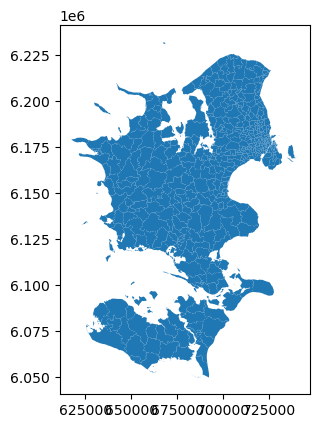

In [7]:
subset = v_areas[v_areas.StorKredsNr.isin([1,2,3,5])]
subset.plot();

**Generate dots:** (this can take a while!)

In [8]:
dots = gen_points_in_gdf_polys(subset.geometry, subset["FV2022 - Afgivne stemmer"],100)

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


**Plot the dots:**

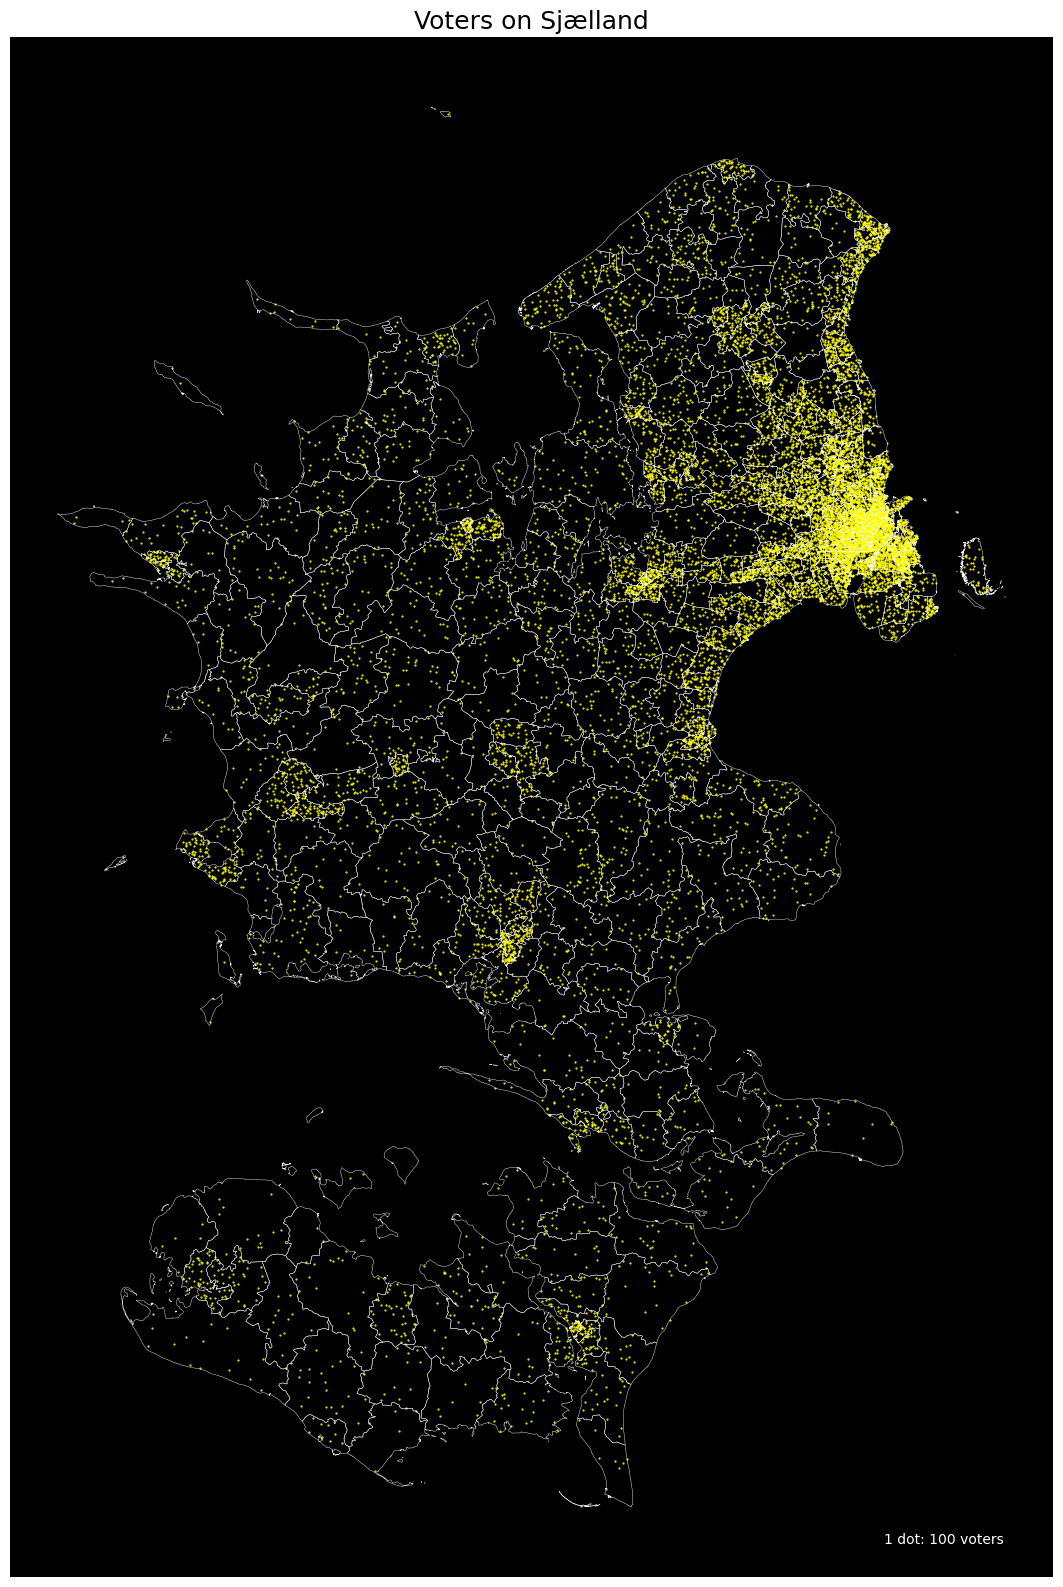

In [9]:
fig, ax = plt.subplots(figsize=(20,20))

ax.set_facecolor("black")

# Turn ax ticks off without affecting face color
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

subset.boundary.plot(ax=ax,edgecolor='white',linewidth=0.3)

dots.plot(ax=ax, markersize=0.3,color='yellow')

ax.text(725000, 6045000, '1 dot: 100 voters',color='white')

plt.title("Voters on Sjælland",fontsize=18);